In [119]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [57]:
clusters = pd.read_hdf('clusters_with_aircrafts_all_months.h5')
clusters.drop_duplicates(inplace=True, ignore_index=True)
clusters = clusters[clusters.cluster_time != 0]
clusters['running_cluster_index'] = np.cumsum(np.abs(clusters.time_cluster.diff())>0)

In [59]:
clusters.head(15)

,station_number,run_number,event_number,readout_time,read_trigger_difference,trigger_time,mattak_trigger_time,force_trigger,radiant_trigger,lt_trigger,pps_num,sysclk,sysclk_last_pps,sysclk_last_last_pps,station,sysclks_ok,run_type,time_since_first,time_cluster,time_cluster_size,x,y,z,hexcode,flightnumber,rssi,cluster_time,running_cluster_index
0,22,86,1,1.627085e+09,-0.460160,1.627085e+09,1.627085e+09,False,False,False,3,300000264,300000262,200000155,22,True,not specified,6.895830e+05,1851674,3,NaN,NaN,NaN,NONE_FOUND,NONE_FOUND,NaN,1.627085e+09,0
1,22,86,2,1.627085e+09,-0.001984,1.627085e+09,1.627085e+09,False,False,False,5,500000462,500000460,400000358,22,True,not specified,6.895830e+05,1851674,3,NaN,NaN,NaN,NONE_FOUND,NONE_FOUND,NaN,1.627085e+09,0
2,22,86,0,1.627085e+09,-0.488737,1.627085e+09,1.627085e+09,False,False,False,2,200000157,200000155,100000075,22,True,not specified,6.895830e+05,1851674,3,NaN,NaN,NaN,NONE_FOUND,NONE_FOUND,NaN,1.627085e+09,0
3,22,87,1,1.627092e+09,-0.298171,1.627092e+09,1.627092e+09,False,False,False,5,500000260,500000258,400000211,22,True,not specified,6.967900e+05,1861574,3,NaN,NaN,NaN,NONE_FOUND,NONE_FOUND,NaN,1.627092e+09,1
4,22,87,0,1.627092e+09,-0.324630,1.627092e+09,1.627092e+09,False,False,False,4,400000213,400000211,300000158,22,True,not specified,6.967900e+05,1861574,3,NaN,NaN,NaN,NONE_FOUND,NONE_FOUND,NaN,1.627092e+09,1
5,22,87,2,1.627092e+09,0.000314,1.627092e+09,1.627092e+09,False,False,False,6,600000288,600000286,500000258,22,True,not specified,6.967900e+05,1861574,3,NaN,NaN,NaN,NONE_FOUND,NONE_FOUND,NaN,1.627092e+09,1
6,22,90,0,1.627114e+09,-0.172738,1.627114e+09,1.627114e+09,False,False,False,2,200000030,200000028,100000003,22,True,not specified,7.184100e+05,1891284,3,NaN,NaN,NaN,NONE_FOUND,NONE_FOUND,NaN,1.627114e+09,2
7,22,90,1,1.627114e+09,-0.143147,1.627114e+09,1.627114e+09,False,False,False,3,300000036,300000034,200000028,22,True,not specified,7.184100e+05,1891284,3,NaN,NaN,NaN,NONE_FOUND,NONE_FOUND,NaN,1.627114e+09,2
8,22,90,2,1.627114e+09,0.000865,1.627114e+09,1.627114e+09,False,False,False,4,400000054,400000052,300000034,22,True,not specified,7.184100e+05,1891284,3,NaN,NaN,NaN,NONE_FOUND,NONE_FOUND,NaN,1.627114e+09,2
9,22,91,0,1.627121e+09,-0.040267,1.627121e+09,1.627121e+09,False,False,False,3,300000231,300000229,200000153,22,True,not specified,7.256160e+05,1901857,3,NaN,NaN,NaN,NONE_FOUND,NONE_FOUND,NaN,1.627121e+09,3


In [60]:
np.max(clusters.time_cluster_size.unique()) # cant trust time_cluster_size, h5 file contains duplicate values

37

In [72]:
unique_clusters = clusters.running_cluster_index.unique()
cluster_size_check = []
for cluster_index in unique_clusters:
    tmp = clusters[clusters.running_cluster_index == cluster_index] # get rows that belong to current cluster
    size = len(tmp) # get cluster size
    num_stations = len(tmp.station.unique()) # get number of stations in cluster (should match cluster size in best case)
    cluster_size_check.append([size, num_stations])
cluster_size_check = np.array(cluster_size_check)

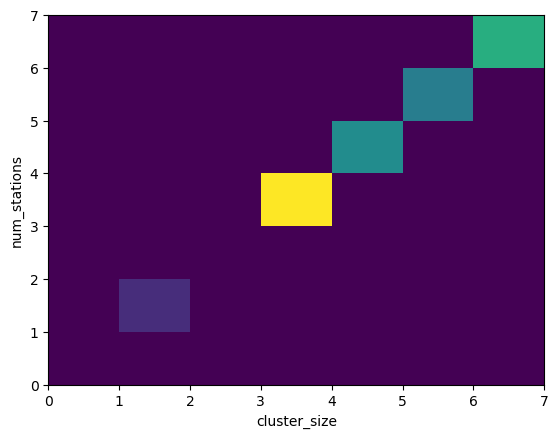

In [75]:
edges = range(8)
plt.hist2d(cluster_size_check[:, 0], cluster_size_check[:, 1], bins = [edges, edges])
plt.xlabel('cluster_size')
plt.ylabel('num_stations')
plt.show()

In [76]:
len(clusters)

89366

In [87]:
len(clusters[~clusters.rssi.isna()])

86979

In [112]:
clusters_of_interest = clusters[~(clusters.rssi.isna() | clusters.x.isna() | clusters.y.isna())][['station_number', 'rssi', 'x', 'y']]

In [113]:
clusters_of_interest['x'] = clusters_of_interest.x / 1000
clusters_of_interest['y'] = clusters_of_interest.y / 1000
data = clusters_of_interest

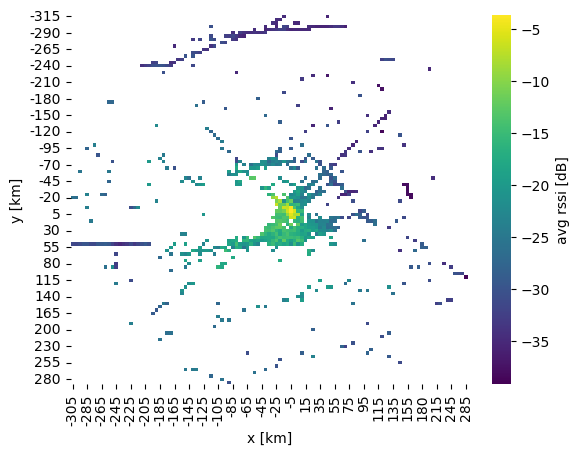

In [164]:
bin_size = 5 # km

data['x_bin'] = ((data['x']) // bin_size).astype(int) * bin_size
data['y_bin'] = ((data['y']) // bin_size).astype(int) * bin_size

averaged_data = data.groupby(['x_bin', 'y_bin'])['rssi'].mean().reset_index()

pivot_table = averaged_data.pivot(index='y_bin', columns='x_bin', values='rssi')

x_edges = np.arange(data['x'].min(), data['x'].max() + bin_size, bin_size).astype(int)
y_edges = np.arange(data['y'].min(), data['y'].max() + bin_size, bin_size).astype(int)

sns.heatmap(pivot_table, cmap='viridis', cbar_kws={'label': 'avg rssi [dB]'})
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()

In [172]:
data[np.abs(data.x) < 5 & (data.x > 0)].sort_values(by = 'x').head(40)

,station_number,rssi,x,y,x_bin,y_bin
21492,21,-3.962007,0.001566,0.391889,0,0
21493,11,-3.962006,0.001567,0.391890,0,0
21494,12,-3.962006,0.001567,0.391890,0,0
21495,23,-3.962006,0.001567,0.391890,0,0
21496,13,-3.962006,0.001567,0.391890,0,0
21497,24,-3.962005,0.001567,0.391890,0,0
17706,13,-4.158304,0.003151,0.327396,0,0
17705,11,-4.158306,0.003152,0.327397,0,0
17704,21,-4.158307,0.003152,0.327397,0,0
27407,11,-3.257481,0.003315,4.337026,0,0
